### **Does Fighter Age Affect Fighter Performance?**

The code below merges date of birth into fight history and computes the each fighter's age at the time of their fight. From there, it is possible to determine what effect age is having on performance.

In [25]:
import pandas as pd

# Load
attrs = pd.read_csv("data/fighter_attributes.csv")
hist = pd.read_csv("data/fighter_history.csv")

# Convert date columns
attrs['dob'] = pd.to_datetime(attrs['dob'], errors='coerce')
hist['event_date'] = pd.to_datetime(hist['event_date'], errors='coerce')

# Merge DOB into fight history
merged = hist.merge(
    attrs[['fighter_id', 'dob', 'weight_class', 'style']], 
    on='fighter_id', 
    how='left'
)

# Compute age at fight (years)
merged['age_at_fight'] = (merged['event_date'] - merged['dob']).dt.days / 365.25

merged = merged[(merged['age_at_fight'] >= 18) & (merged['age_at_fight'] <= 45)]
merged['age_at_fight'].describe()

merged[['fighter_id', 'event_date', 'dob', 'age_at_fight']].head()

,fighter_id,event_date,dob,age_at_fight
0,3332412,2025-01-18,1991-10-27,33.229295
1,3332412,2024-06-01,1991-10-27,32.596851
2,3332412,2023-10-21,1991-10-27,31.983573
3,3332412,2023-02-11,1991-10-27,31.293634
4,3332412,2022-10-22,1991-10-27,30.986995


This code calculates win rate by age group. The age groups were somewhat arbitrarily assigned so that they were evenly spaced, but it should allow us to get a good idea of how age isaffecting performance.

In [12]:
bins = [18, 25, 30, 35, 40, 45]
labels = ['18–24', '25–29', '30–34', '35–39', '40+']

merged['age_group'] = pd.cut(merged['age_at_fight'], bins=bins, labels=labels)

win_rates = merged.groupby('age_group')['fight_result'].apply(lambda x: (x=='W').mean())
win_rates

C:\Users\Ian Campbell\AppData\Local\Temp\ipykernel_2688\3693894337.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates = merged.groupby('age_group')['fight_result'].apply(lambda x: (x=='W').mean())


age_group
18–24    0.581139
25–29    0.534483
30–34    0.479173
35–39    0.408884
40+      0.363265
Name: fight_result, dtype: float64

As you can see above, the win rate obviously decreases as the age rises. This suggests that as fighter age increases, performance decreases. This will be statistically tested in the following code.

In [13]:
# Win = 1, Loss/Other = 0
merged['win_binary'] = (merged['fight_result'] == 'W').astype(int)

# Age brackets (modify if needed)
bins = [18, 25, 30, 35, 40, 45, 60]
labels = ['18–24', '25–29', '30–34', '35–39', '40–44', '45+']

merged['age_group'] = pd.cut(merged['age_at_fight'], bins=bins, labels=labels)

win_table = pd.crosstab(merged['age_group'], merged['win_binary'])
print(win_table)

from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(win_table)

print("Chi-square:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)

win_binary     0     1
age_group             
18–24        684   949
25–29       3213  3689
30–34       3351  3083
35–39       1171   810
40–44        156    89
Chi-square: 170.98577108878146
Degrees of freedom: 4
p-value: 6.425278434225075e-36


The results of this chi-squared test show that age groups are in fact statistically significant. Below, is a bar chart showing win rate as age group increases.

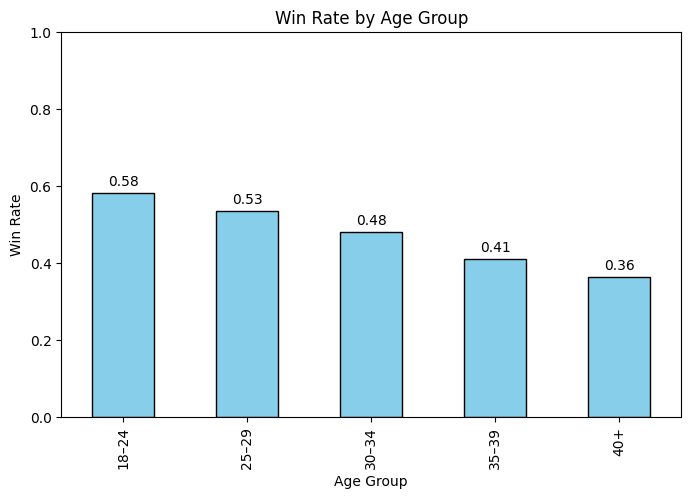

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

win_rates.plot(
    kind='bar',
    color='skyblue',
    edgecolor='black'
)

plt.ylabel("Win Rate")
plt.xlabel("Age Group")
plt.title("Win Rate by Age Group")
plt.ylim(0, 1)

# Label each bar with the exact win rate value
for i, v in enumerate(win_rates.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

This bar chart shows visually how win rate decreases with increasing age group. Next, it is important to test this on a continuous level by using logistic regression to see if there is a negative correlation between age increase and win rate.

In [15]:
import numpy as np
import statsmodels.api as sm

# Use the filtered data
df = merged.dropna(subset=['age_at_fight']).copy()

# Make sure win_binary exists (you already created it earlier, but this is safe)
if 'win_binary' not in df.columns:
    df['win_binary'] = (df['fight_result'] == 'W').astype(int)

# Logistic regression: win_binary ~ age_at_fight
X = sm.add_constant(df['age_at_fight'])
y = df['win_binary']

logit_model = sm.Logit(y, X).fit()
coef = logit_model.params['age_at_fight']
intercept = logit_model.params['const']
p_val = logit_model.pvalues['age_at_fight']

# X-axis for regression curve (will now start at the *filtered* min age)
ages = np.linspace(df['age_at_fight'].min(), df['age_at_fight'].max(), 300)

# Predicted probabilities from the model
log_odds = intercept + coef * ages
probabilities = 1 / (1 + np.exp(-log_odds))

Optimization terminated successfully.
         Current function value: 0.687291
         Iterations 4


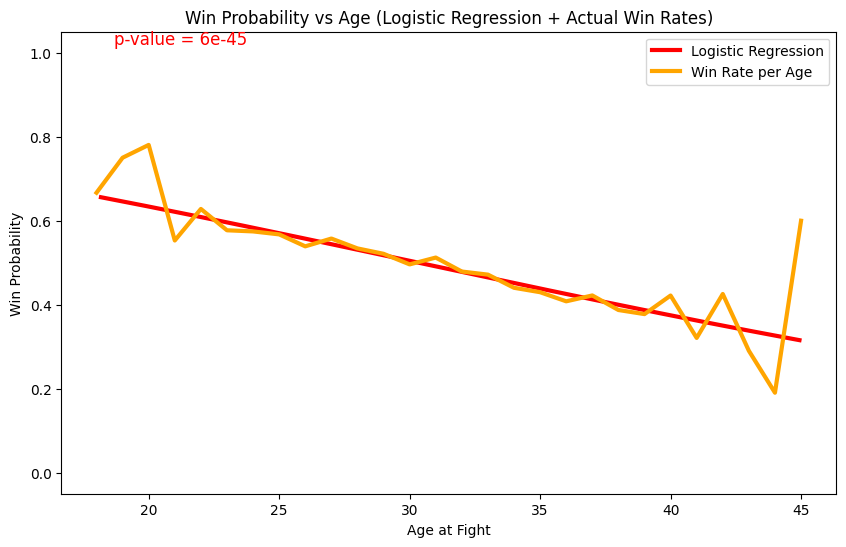

In [16]:

plt.figure(figsize=(10,6))

# Logistic regression curve
plt.plot(ages, probabilities, color="red", linewidth=3, label="Logistic Regression")

# Actual win rate per age (unsmoothed)
binned = df.copy()
binned['age_round'] = binned['age_at_fight'].round()

age_win_rate = binned.groupby('age_round')['win_binary'].mean()

plt.plot(age_win_rate.index, age_win_rate.values,
         color='orange', linewidth=3, label="Win Rate per Age")

plt.xlabel("Age at Fight")
plt.ylabel("Win Probability")
plt.title("Win Probability vs Age (Logistic Regression + Actual Win Rates)")
plt.legend()
plt.ylim(-0.05, 1.05)

# Add p-value on chart
plt.text(
    x=df['age_at_fight'].min() + 0.5,
    y=1.02,
    s=f"p-value = {p_val:.3g}",
    fontsize=12,
    color="red"
)

plt.show()

This regression plot shows that there is a predictable decrease in fighter performance with age. One interesting thing is the brief peak in win rate at around age 47. This is most likely due to an outlier data point causing the win rate to spike, since there are not many fights happening at age 47. The orange curve also gives an idea of when a fighter's peak age occurs. To understand exactly where this occurs, I used the code below:

In [10]:
peak_age = age_win_rate.idxmax()
peak_rate = age_win_rate.max()
print("Peak Age:", peak_age)
print("Peak Win Rate:", peak_rate)

Peak Age: 47.0
Peak Win Rate: 1.0


One thing you often here is that, as you get older and take more hits, it becomes more likely that the fighter will be knocked out. The below code seeks to find out if this is true.

In [21]:
import statsmodels.api as sm
import numpy as np

# Filtered dataset (df must already contain age_at_fight and win_binary)
# Create KO_suffered variable
df['ko_suffered'] = ((df['fight_result'] == 'L') & 
                     (df['fight_result_type'] == 'KO-TKO')).astype(int)

# Drop missing values for regression
df2 = df.dropna(subset=['age_at_fight', 'ko_suffered']).copy()

# Logistic regression: ko_suffered ~ age_at_fight
X_ko = sm.add_constant(df2['age_at_fight'])
y_ko = df2['ko_suffered']

ko_model = sm.Logit(y_ko, X_ko).fit()

coef_ko = ko_model.params['age_at_fight']
intercept_ko = ko_model.params['const']
p_val_ko = ko_model.pvalues['age_at_fight']

# X-axis for the KO regression curve
ages_ko = np.linspace(df2['age_at_fight'].min(), df2['age_at_fight'].max(), 300)

# Predicted probabilities
log_odds_ko = intercept_ko + coef_ko * ages_ko
prob_ko = 1 / (1 + np.exp(-log_odds_ko))

df2['age_round'] = df2['age_at_fight'].round()

ko_rate_by_age = df2.groupby('age_round')['ko_suffered'].mean()

Optimization terminated successfully.
         Current function value: 0.424281
         Iterations 6


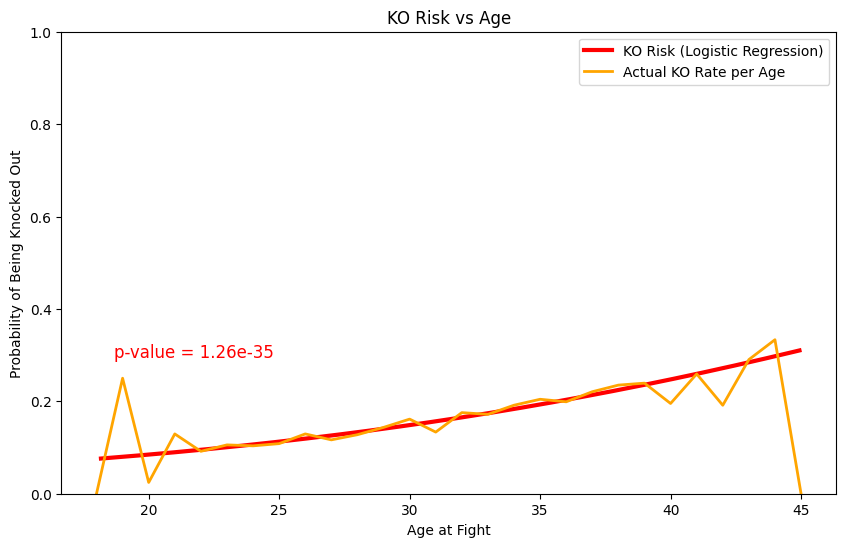

In [22]:
plt.figure(figsize=(10,6))

plt.plot(ages_ko, prob_ko, color="red", linewidth=3, label="KO Risk (Logistic Regression)")
plt.plot(ko_rate_by_age.index, ko_rate_by_age.values,
         color='orange', linewidth=2, label="Actual KO Rate per Age")

plt.xlabel("Age at Fight")
plt.ylabel("Probability of Being Knocked Out")
plt.title("KO Risk vs Age")

plt.text(
    x=df2['age_at_fight'].min() + 0.5,
    y=prob_ko.max() * 0.95,
    s=f"p-value = {p_val_ko:.3g}",
    fontsize=12,
    color="red"
)

plt.ylim(0, 1)
plt.legend()
plt.show()

This regression along with the p value shows a strong positive relationship between increasing age and increasing likelihood of getting knocked out, which supports the commonly expressed belief that taking more punches over a long career leads to a higher chance of getting knocked out. To test this theory even further, I have decided to look not just at age but also at ko risk compared to number of fights, as well as weight class, and fighter style. Then, I will do multivariate statistical analysis to determine what the greatest factor is, which leads to knock outs.

The below code examines fight mileage (# of career fights) and kos suffered

In [23]:
df = df.sort_values(['fighter_id', 'event_date'])
df['fight_number'] = df.groupby('fighter_id').cumcount() + 1

X = sm.add_constant(df['fight_number'])
y = df['ko_suffered']

model_fights = sm.Logit(y, X).fit()
print(model_fights.summary())

Optimization terminated successfully.
         Current function value: 0.428432
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            ko_suffered   No. Observations:                17195
Model:                          Logit   Df Residuals:                    17193
Method:                           MLE   Df Model:                            1
Date:                Sat, 06 Dec 2025   Pseudo R-squ.:               0.0008314
Time:                        12:24:48   Log-Likelihood:                -7366.9
converged:                       True   LL-Null:                       -7373.0
Covariance Type:            nonrobust   LLR p-value:                 0.0004629
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.7900      0.032    -56.096      0.000      -1.853      -1.727
fight_number     0.0123

In [26]:
weight_dummies = pd.get_dummies(df['weight_class'], drop_first=True)
X = sm.add_constant(weight_dummies)
y = df['ko_suffered']

model_weight = sm.Logit(y, X).fit()
print(model_weight.summary())



KeyError: 'weight_class'